In [ ]:
import pandas as pd
from datasets import Dataset, DatasetDict
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, TrainingArguments, Trainer
import torch
import numpy as np
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import csv

# Load preprocessed data with robust error handling
def load_data():
    drive_path = "datasets/"
    train = pd.read_csv(f"{drive_path}train.csv", on_bad_lines='skip', quoting=csv.QUOTE_NONE, encoding='utf-8', engine='python')
    val = pd.read_csv(f"{drive_path}valid.csv", on_bad_lines='skip', quoting=csv.QUOTE_NONE, encoding='utf-8', engine='python')
    test = pd.read_csv(f"{drive_path}test.csv", on_bad_lines='skip', quoting=csv.QUOTE_NONE, encoding='utf-8', engine='python')

    # Sample a smaller subset of the training, validation, and test data
    mini_train = train.sample(n=min(7000, len(train)), random_state=42)
    mini_val = val.sample(n=min(1000, len(val)), random_state=42) # Sample 1000 for validation
    mini_test = test.sample(n=min(1000, len(test)), random_state=42) # Sample 1000 for test


    return mini_train, mini_val, mini_test


# Convert pandas to HuggingFace Dataset
def preprocess_data(train, val, test):
    columns = ["func", "target"]
    train_ds = Dataset.from_pandas(train[columns])
    val_ds = Dataset.from_pandas(val[columns])
    test_ds = Dataset.from_pandas(test[columns])
    return DatasetDict({"train": train_ds, "validation": val_ds, "test": test_ds})

# Tokenization
tokenizer = AutoTokenizer.from_pretrained("Salesforce/codet5-base")

def tokenize(batch):
    # Ensure 'func' and 'target' exist and are valid
    if "func" not in batch or "target" not in batch:
        raise ValueError("Missing required fields in batch")

    # Check for None or NaN values in 'func'
    texts = [x if isinstance(x, str) else "" for x in batch["func"]]
    # Check for None or NaN values in 'target' and handle them
    labels = []
    for t in batch["target"]:
        if t is None or pd.isna(t):
            labels.append("no") # Assign a default value for None/NaN entries
        else:
            try:
                labels.append("yes" if int(t) == 1 else "no")
            except ValueError:
                labels.append("no") # Assign a default value for invalid entries


    model_inputs = tokenizer(
        texts,
        padding="max_length",
        truncation=True,
        max_length=512
    )

    labels_enc = tokenizer(
        text_target=labels, # Use text_target for labels
        padding="max_length",
        truncation=True,
        max_length=10
    )

    model_inputs["labels"] = labels_enc["input_ids"]
    return model_inputs


# Compute metrics
def compute_metrics(pred):
    labels = pred.label_ids
    preds = np.argmax(pred.predictions, axis=-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='binary')
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "f1": f1, "precision": precision, "recall": recall}

# Main training routine
def main():
    train_df, val_df, test_df = load_data()
    dataset = preprocess_data(train_df, val_df, test_df)
    tokenized = dataset.map(tokenize, batched=True)

    model = AutoModelForSeq2SeqLM.from_pretrained("Salesforce/codet5-base")

    training_args = TrainingArguments(
        output_dir="model_codet5_finetuned",
        per_device_train_batch_size=2,  # Reduced batch size
        per_device_eval_batch_size=2,   # Reduced batch size
        num_train_epochs=1,
        eval_strategy="no",  # Skip evaluation during training
        save_strategy="epoch",
        logging_dir="logs",
        load_best_model_at_end=False, # Set to False when eval_strategy is "no"
        save_total_limit=1
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=tokenized["train"],
        eval_dataset=tokenized["validation"],
        tokenizer=tokenizer,
        compute_metrics=compute_metrics
    )

    trainer.train()
    trainer.save_model("datasets/model_codet5_finetuned") # Updated save path

if __name__ == '__main__':
    main()

Map:   0%|          | 0/7000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/892M [00:00<?, ?B/s]

/tmp/ipython-input-3086948441.py:101: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


model.safetensors:   0%|          | 0.00/892M [00:00<?, ?B/s]

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: jainarushi651 (jainarushi651-queen-mary-university-of-london) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Step,Training Loss
500,0.055000
1000,0.008000
1500,0.002600
2000,0.002500
2500,0.001900
3000,0.001500
3500,0.000800



--- Classification Report ---
              precision    recall  f1-score   support

        Safe       0.55      0.03      0.06      1477
  Vulnerable       0.46      0.97      0.62      1255

    accuracy                           0.46      2732
   macro avg       0.50      0.50      0.34      2732
weighted avg       0.51      0.46      0.32      2732



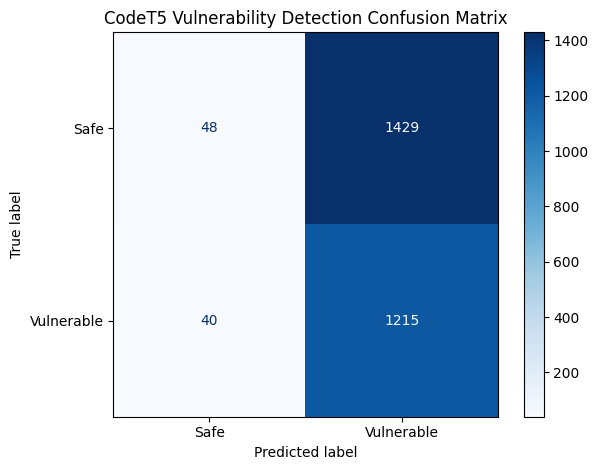

In [ ]:
# Evaluate fine-tuned CodeT5 model on test set

import pandas as pd
import numpy as np
from datasets import Dataset
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import torch

# Load test dataset
# Assuming the test data is located in your Google Drive
drive_path = "datasets/" # IMPORTANT: Replace with your actual folder path in Google Drive
test_df = pd.read_csv(f"{drive_path}test.csv").sample(1000, random_state=42)
test_dataset = Dataset.from_pandas(test_df[["func", "target"]])


# Load fine-tuned model and tokenizer
MODEL_DIR = "datasets/model_codet5_finetuned" # Load from Google Drive
tokenizer = AutoTokenizer.from_pretrained(MODEL_DIR)
model = AutoModelForSeq2SeqLM.from_pretrained(MODEL_DIR)
model.eval()
if torch.cuda.is_available():
    model.to("cuda")

# Prediction function
def predict(batch):
    prompt = batch["func"]
    inputs = tokenizer(prompt, return_tensors="pt", truncation=True, padding="max_length", max_length=512)
    if torch.cuda.is_available():
        inputs = {k: v.to("cuda") for k, v in inputs.items()}

    with torch.no_grad():
        outputs = model.generate(**inputs, max_length=10)
    decoded = tokenizer.decode(outputs[0], skip_special_tokens=True).lower()
    return 1 if "yes" in decoded else 0

# Run predictions
y_true = test_df["target"].tolist()
y_pred = []

for sample in test_df["func"]:
    y_pred.append(predict({"func": sample}))

# Print metrics
print("\n--- Classification Report ---")
print(classification_report(y_true, y_pred, target_names=["Safe", "Vulnerable"]))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Safe", "Vulnerable"])
disp.plot(cmap="Blues")
plt.title("CodeT5 Vulnerability Detection Confusion Matrix")
plt.tight_layout()
plt.show()